# Setting up dependencies

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import torch
import math

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


data_path = './data/'

from sliceduot.sliced_barycenter import compute_barycenter_grid_MD_unbalanced

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Loading dataset


In [2]:
ds = xr.open_mfdataset(data_path+'test/*2011*.nc') # loading all datasets for 2003-2004

In [3]:
stride=1
data_TMQ = ds['TMQ'].values[:,::stride,::stride]

In [4]:
final_im = ds['TMQ'].values[0]

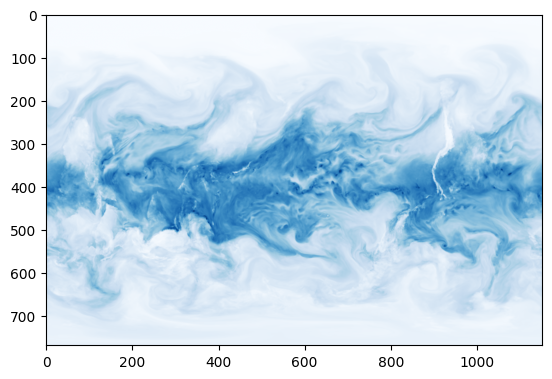

In [5]:
plt.imshow(final_im,cmap='Blues')

In [6]:
ds_mean = xr.Dataset(
    data_vars=dict(average=(["lat", "lon"], final_im)),
    coords=dict(lon=(["lon"], ds['lon'].data[::stride]),lat=(["lat"], ds['lat'].data[::stride])),
    attrs=dict(description="Average TMQ.")
)

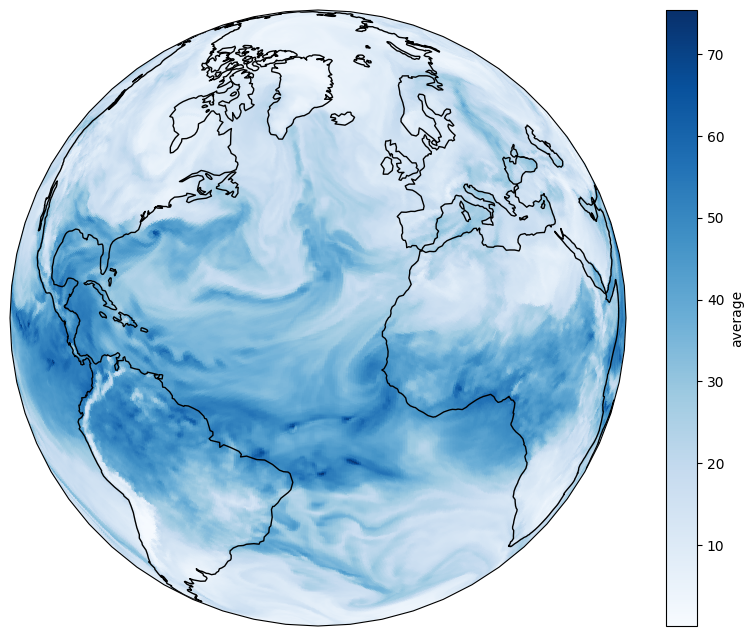

In [7]:
p = ds_mean['average'].plot(transform=ccrs.PlateCarree(),
      subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
      aspect = 1.3, size = 8,
      cmap='Blues'
    )
p.axes.coastlines()
plt.draw()

In [8]:
t_image = torch.from_numpy(final_im).reshape(1,final_im.shape[0]*final_im.shape[1])
coef = .08
t_image = torch.nn.functional.softmax(coef*t_image,dim=1).reshape(1,final_im.shape[0],final_im.shape[1])


In [9]:
import torch
import torchvision.transforms as T

torch.manual_seed(2023)

#alpha (float or sequence of python:floats) – Magnitude of displacements. Default is 50.0.
#sigma (float or sequence of python:floats) – Smoothness of displacements. Default is 5.0.
num_im= 4
sel = range(num_im)

elastic_transformer = T.ElasticTransform(alpha=400.0,sigma=12.0, fill=1e-6)
transformed_imgs = np.array([elastic_transformer(t_image).squeeze().numpy() for _ in sel])

In [10]:
# normalization of the entire scene
full_data = torch.from_numpy(transformed_imgs).reshape(transformed_imgs.shape[0],-1).float()


scaled_imgs = full_data.reshape(transformed_imgs.shape[0],transformed_imgs.shape[1],transformed_imgs.shape[2]).numpy()

In [11]:
full_data.shape

torch.Size([4, 884736])

/tmp/ipykernel_12665/3021694667.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


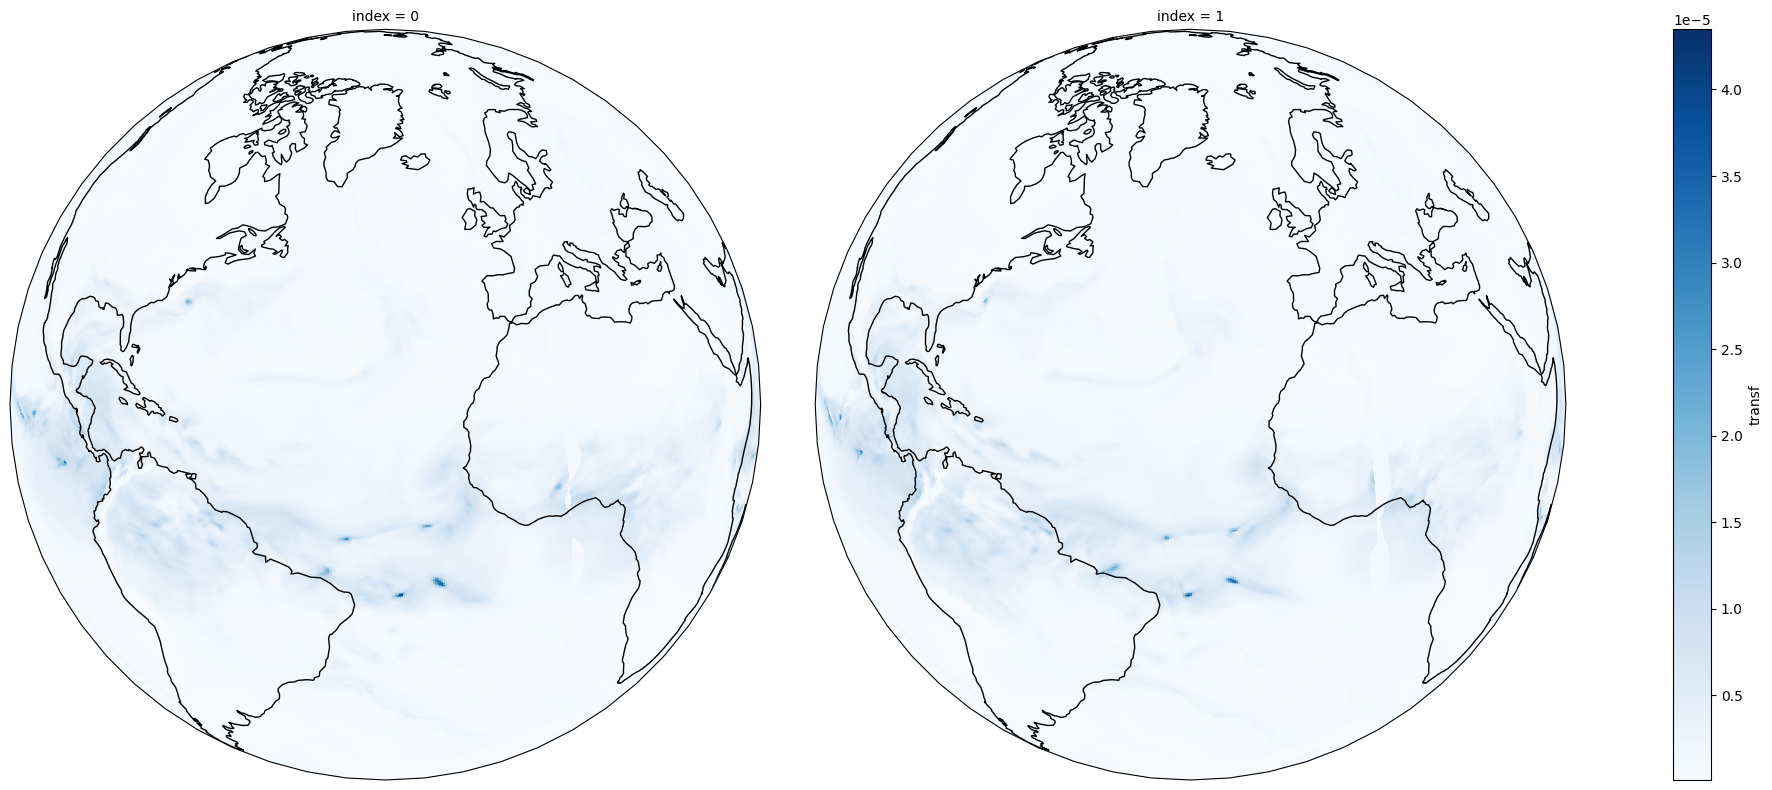

In [12]:
t_im = xr.Dataset(data_vars=dict(transf=(["index", "lat", "lon"], scaled_imgs)),
                  coords=dict(index=(["index"], sel),lon=(["lon"], ds['lon'].data),lat=(["lat"], ds['lat'].data))
                  )
p = t_im['transf'].isel(index=[0,1]).plot(transform=ccrs.PlateCarree(),
      subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
      col="index",
      aspect = 1.3, size = 8,
      cmap='Blues'
    )
for ax in p.axes.flat:
  ax.coastlines()
plt.draw()


## subsel

In [13]:
sel_lon = np.where(np.logical_and(ds['lon']>270, ds['lon']<320))[0]
sel_lat = np.where(np.logical_and(ds['lat']>31, ds['lat']<50))[0]

values= scaled_imgs[:,sel_lat,:][:,:,sel_lon]

/tmp/ipykernel_12665/2699412060.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i,ax in enumerate(p.axes.flat):


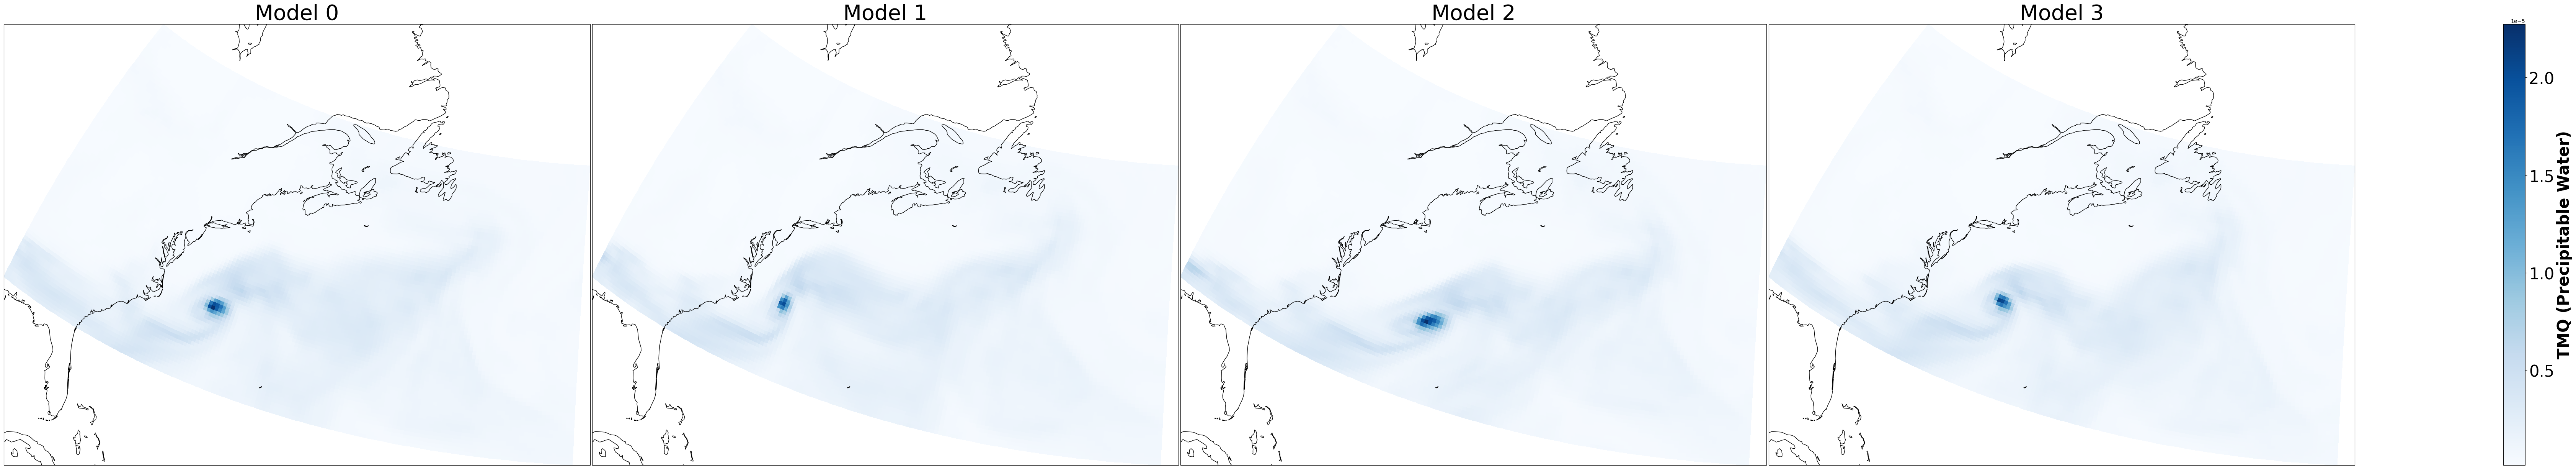

In [14]:
vmin=0
vmax=8e-4

t_im = xr.Dataset(data_vars=dict(TMQ=(["Model", "lat", "lon"], values)),
                  coords=dict(Model=(["Model"], sel),lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
                  )
p = t_im['TMQ'].isel(Model=sel).plot(transform=ccrs.PlateCarree(),
      subplot_kws={"projection": ccrs.Orthographic(-35, 35)},
      cbar_kwargs={"orientation": "vertical","shrink": 1.,"aspect": 20},
      col="Model",
      aspect = 1.6, size = 12,#vmin=vmin,vmax=vmax,
      cmap='Blues'
    )
p.cbar.ax.tick_params(labelsize=30)
p.cbar.set_label(label='TMQ (Precipitable Water)', size=30, weight='bold')
for i,ax in enumerate(p.axes.flat):
  ax.coastlines()
  ax.set_title('Model {}'.format(i),fontsize=40)
plt.draw()

# SUOT / RSOT Barycenters 

# data preparation

In [15]:
# *** grid
lon = np.arange(sel_lon.shape[0]) / sel_lon.shape[0]
lat = np.arange(sel_lat.shape[0]) / sel_lat.shape[0] 

lonlon, latlat = np.meshgrid(lon.data,lat.data)

grid = np.c_[lonlon.ravel(), latlat.ravel()]
Xgrid= torch.from_numpy(grid).float().to(device) 

# *** data
full_data = torch.from_numpy(values).reshape(-1,values.shape[1]*values.shape[2]).float().to(device)
#full_data = full_data / full_data.sum(1).reshape(-1,1)

full_data = full_data * 75.

In [16]:
full_data

tensor([[1.8640e-04, 1.8525e-04, 1.7907e-04,  ..., 3.5344e-05, 3.6872e-05,
         3.6159e-05],
        [1.6188e-04, 1.7488e-04, 1.8743e-04,  ..., 3.0607e-05, 2.9148e-05,
         2.7237e-05],
        [2.6833e-04, 2.6325e-04, 2.4418e-04,  ..., 3.1230e-05, 3.0878e-05,
         2.9916e-05],
        [1.8586e-04, 1.8661e-04, 1.8397e-04,  ..., 2.9441e-05, 2.7723e-05,
         2.6856e-05]], device='cuda:0')

In [17]:
print(full_data.sum(1))

tensor([1.0525, 1.0220, 0.9892, 1.0081], device='cuda:0')


# compute part

0.5
10


Objective value 0.007469919975847006: 100%|██████████| 3000/3000 [17:30<00:00,  2.85it/s] 


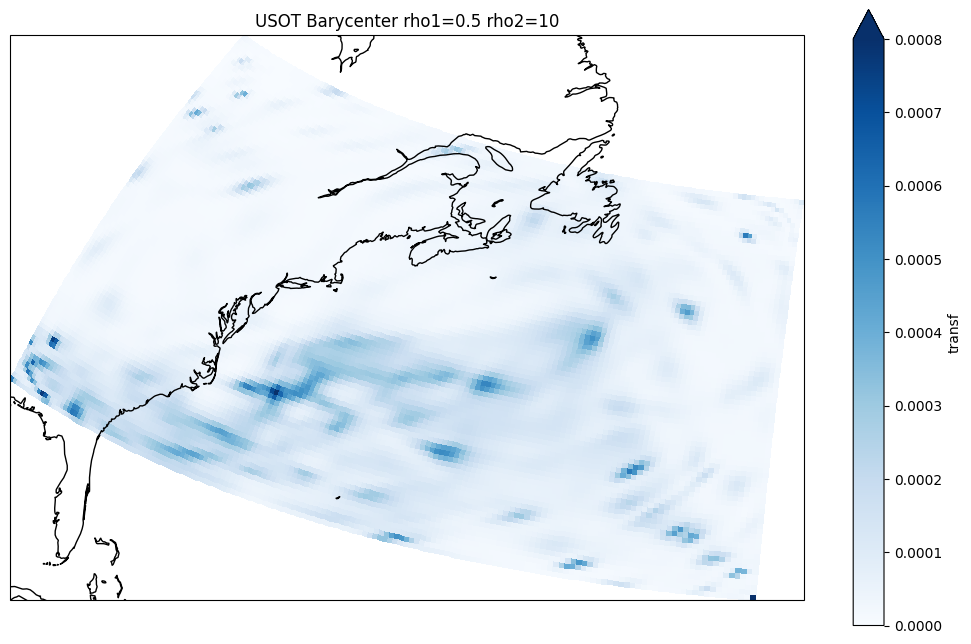

1
10


Objective value 0.004772680811583996: 100%|██████████| 3000/3000 [17:30<00:00,  2.86it/s] 


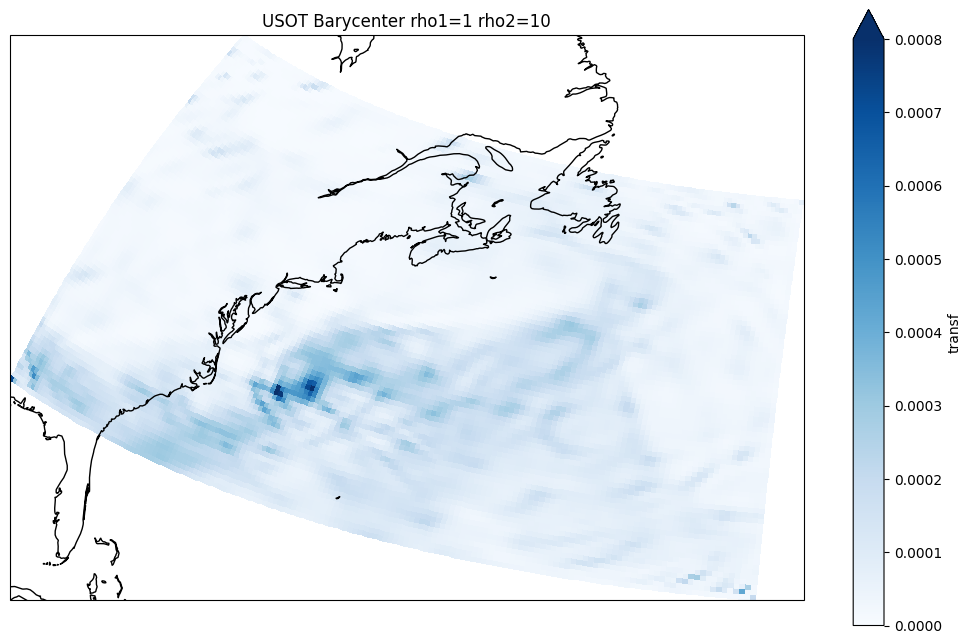

2
10


Objective value 0.0047228895127773285: 100%|██████████| 3000/3000 [17:30<00:00,  2.86it/s]


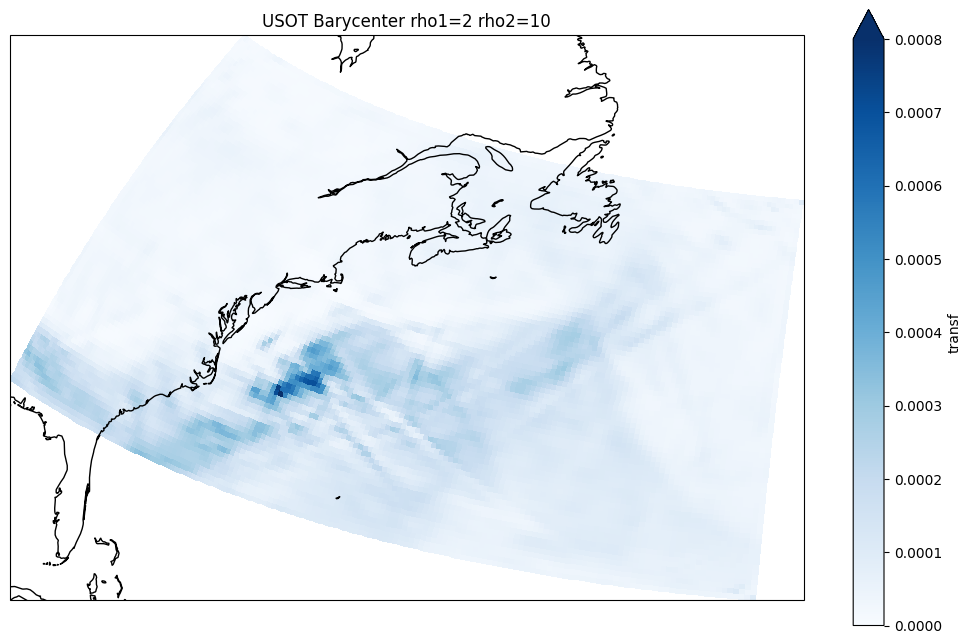

5
10


Objective value 0.0055679501965641975: 100%|██████████| 3000/3000 [17:29<00:00,  2.86it/s]


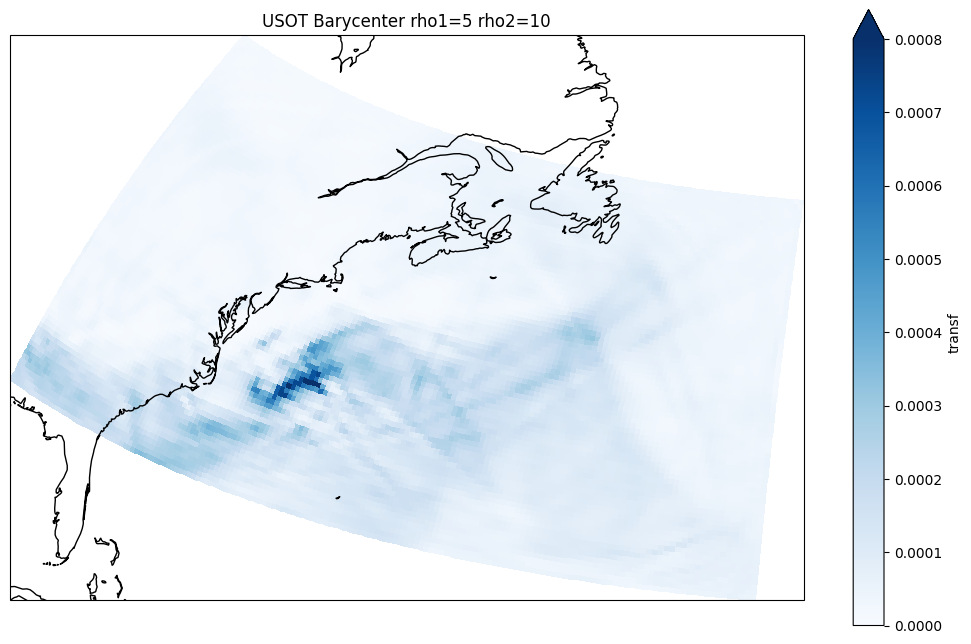

In [18]:
steps = 3000
t0=1e-2
num_proj=64
#rho1= 1e-1
#rho2= 100
innerloop_iter = 10

#tab_rho1 = np.linspace(0.01,0.1,10)#[.01]#np.logspace(-2,2,5)
tab_rho1 = [.5,1,2,5]
tab_rho2 = [10] #np.logspace(-2,2,5)
for rho1 in tab_rho1:
    for rho2 in tab_rho2:
        print(rho1)
        print(rho2)
        barycenter = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1, rho2=rho2,
                                                            bar_iter=steps, fw_iter = innerloop_iter, lr_bar=t0, 
                                                            num_proj=num_proj,p=1)
        t_bary = xr.Dataset(data_vars=dict(transf=(["lat", "lon"], barycenter.reshape(values.shape[1],values.shape[2]).cpu().detach().numpy())),
                    coords=dict(lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
                    )
        p = t_bary['transf'].plot(transform=ccrs.PlateCarree(),
            subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
            aspect = 1.6, size = 8,vmin=vmin,vmax=vmax,
            cmap='Blues'
            )
        p.axes.coastlines()
        plt.draw()
        plt.title('USOT Barycenter rho1={} rho2={}'.format(rho1,rho2))
        plt.savefig('img/USOT_final_3000_rho1={}_rho2={}.png'.format(rho1,rho2))
        plt.show()
    

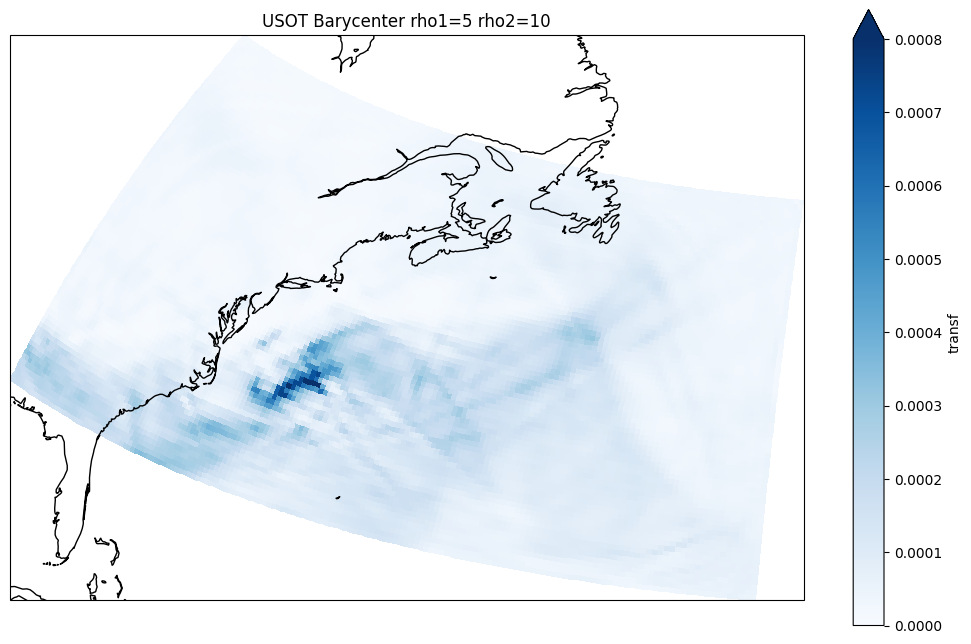

In [19]:
t_bary = xr.Dataset(data_vars=dict(transf=(["lat", "lon"], barycenter.reshape(values.shape[1],values.shape[2]).cpu().detach().numpy())),
            coords=dict(lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
            )
p = t_bary['transf'].plot(transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
    aspect = 1.6, size = 8,vmin=vmin,vmax=8e-4,
    cmap='Blues'
    )
p.axes.coastlines()
plt.draw()
plt.title('USOT Barycenter rho1={} rho2={}'.format(rho1,rho2))
plt.savefig('img/USOT_final_rho1={}_rho2={}.png'.format(rho1,rho2))
plt.show()

Objective value 0.004952113144099712: 100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


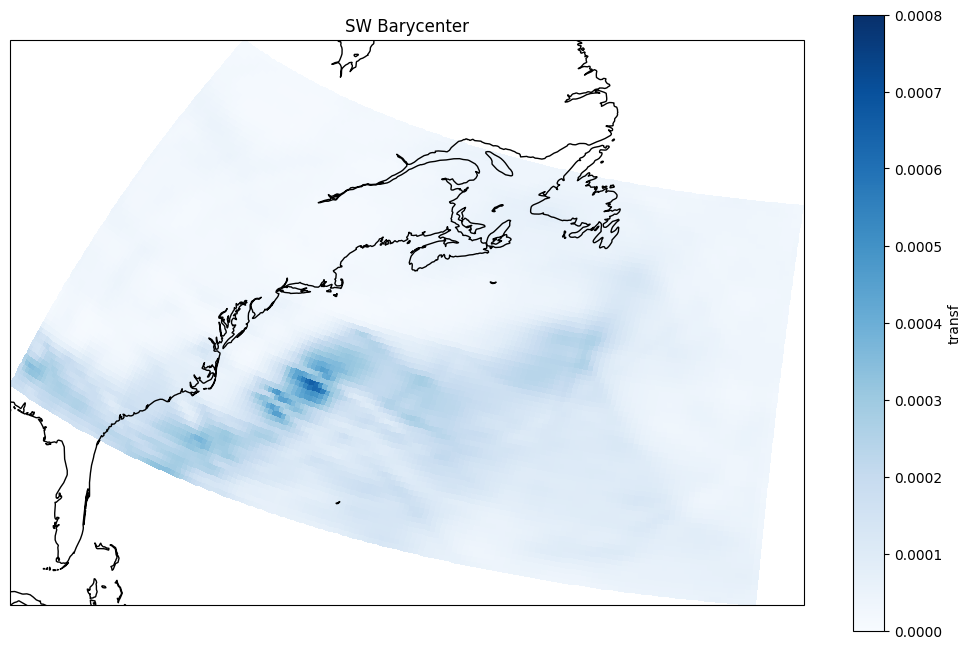

In [20]:
rho1= None
mode = 'backprop'
steps=1000
t0=2e-2
num_proj= 64

normalized_full_data = full_data / full_data.sum(1).reshape(-1,1)
barycenter = compute_barycenter_grid_MD_unbalanced(Xgrid, normalized_full_data, rho1=rho1,
                                                        bar_iter=steps, fw_iter = innerloop_iter, lr_bar=t0, 
                                                        num_proj=num_proj, mode=mode,p=1)
t_bary = xr.Dataset(data_vars=dict(transf=(["lat", "lon"], barycenter.reshape(values.shape[1],values.shape[2]).cpu().detach().numpy())),
                coords=dict(lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
                )
p = t_bary['transf'].plot(transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
    aspect = 1.6, size = 8,vmin=vmin,vmax=vmax,
    cmap='Blues'
    )
p.axes.coastlines()
plt.title('SW Barycenter')
plt.draw()
plt.savefig('img/SW.png')
plt.show()


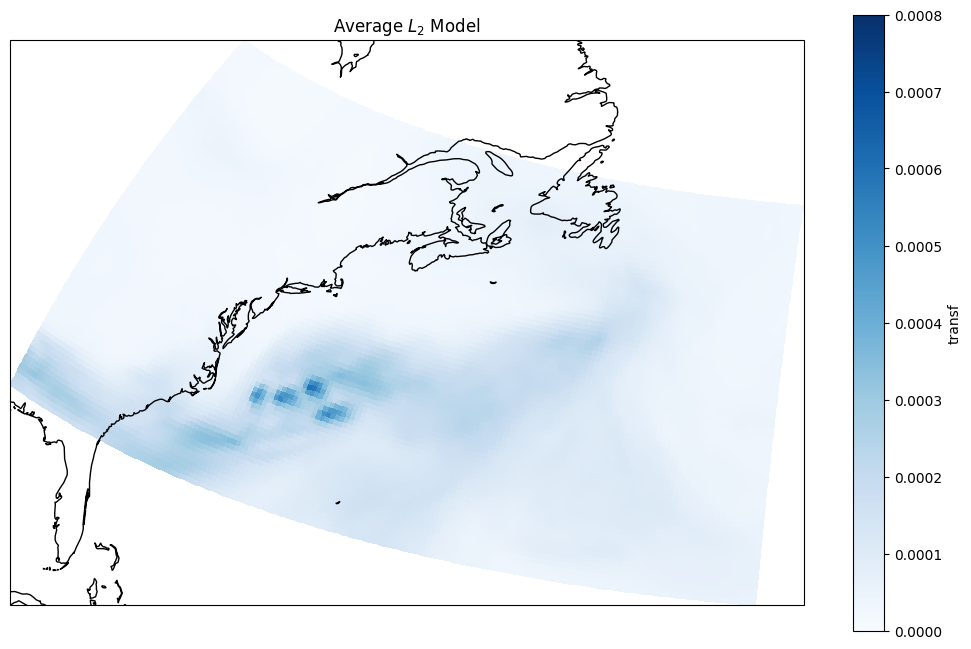

In [21]:
t_bary = xr.Dataset(data_vars=dict(transf=(["lat", "lon"], full_data.mean(0).reshape(values.shape[1],values.shape[2]).cpu().detach().numpy())),
                coords=dict(lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
                )
p = t_bary['transf'].plot(transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(-30, 25)},
    aspect = 1.6, size = 8,vmin=vmin,vmax=vmax,
    cmap='Blues'
    )
p.axes.coastlines()
plt.title('Average $L_2$ Model')
plt.draw()
plt.show()

/tmp/ipykernel_12665/1516236737.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i,ax in enumerate(p.axes.flat):


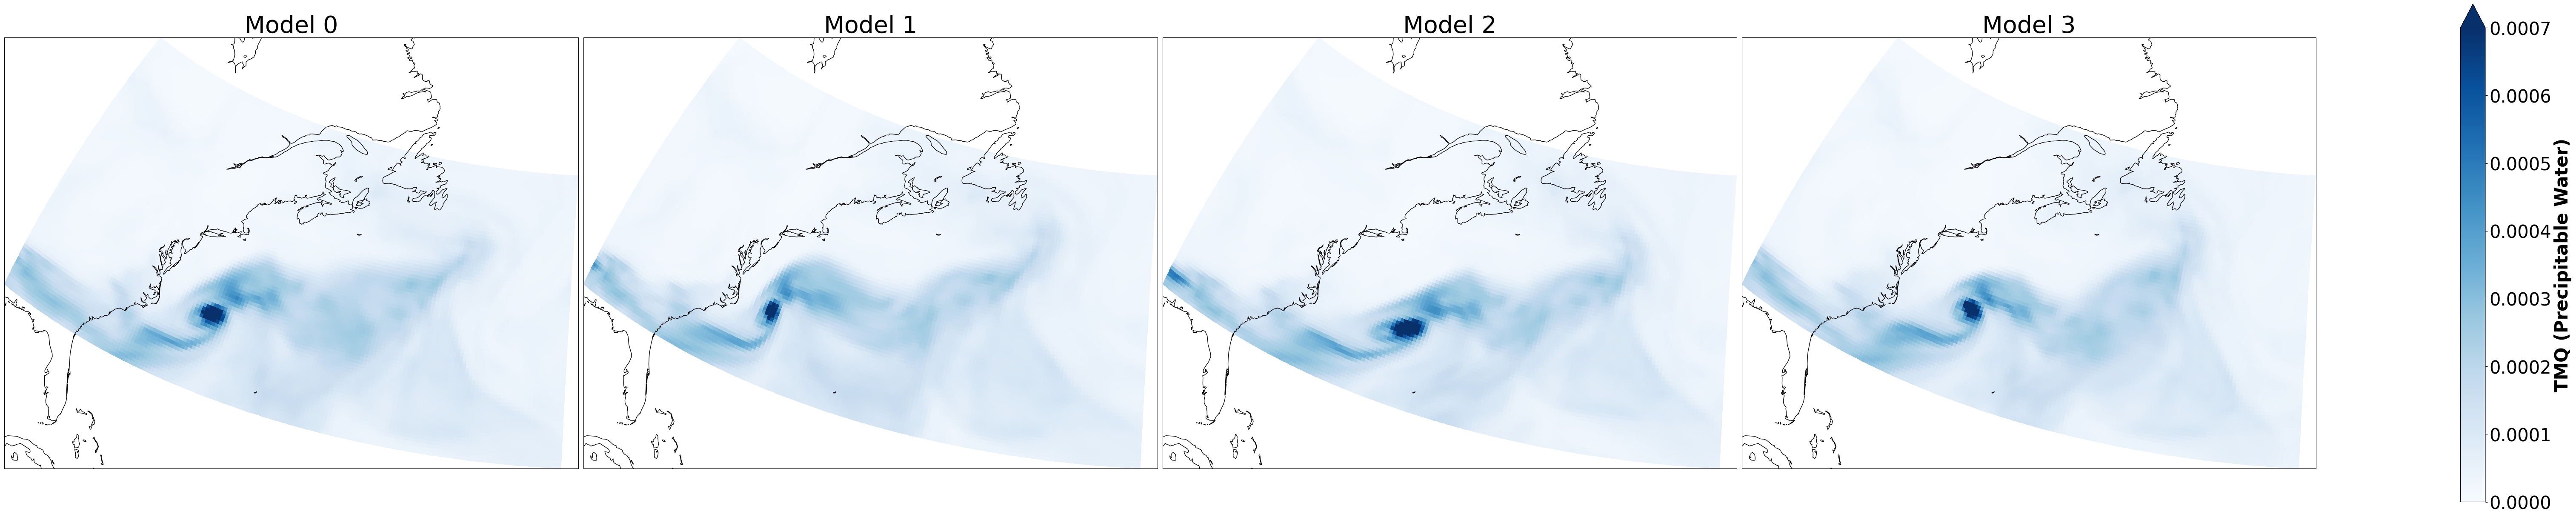

In [22]:
vmin=0
vmax=7e-4

t_im = xr.Dataset(data_vars=dict(TMQ=(["Model", "lat", "lon"], full_data.reshape(-1,values.shape[1],values.shape[2]).cpu().detach().numpy())),
                  coords=dict(Model=(["Model"], sel),lon=(["lon"], ds['lon'].data[sel_lon]),lat=(["lat"], ds['lat'].data[sel_lat]))
                  )
p = t_im['TMQ'].isel(Model=sel).plot(transform=ccrs.PlateCarree(),
      subplot_kws={"projection": ccrs.Orthographic(-35, 35)},
      cbar_kwargs={"orientation": "vertical","shrink": 1.,"aspect": 20},
      col="Model",
      aspect = 1.4, size = 12,vmin=vmin,vmax=vmax,
      cmap='Blues'
    )
p.cbar.ax.tick_params(labelsize=30)
p.cbar.set_label(label='TMQ (Precipitable Water)', size=30, weight='bold')
for i,ax in enumerate(p.axes.flat):
  ax.coastlines()
  ax.set_title('Model {}'.format(i),fontsize=40)
plt.draw()